# LLMs

In [85]:
import sys
sys.path.append("..")
from src.Eval import eval_llm

import os
import io
from contextlib import redirect_stdout

def parse_filename(filename):
    parts = filename.split("_")
    dataset = parts[0]
    k_shot = parts[1].split(".")[0]
    k = int(k_shot.replace("shot", ""))
    return dataset, k

def silent_eval_llm(fpath):
    with io.StringIO() as buf, redirect_stdout(buf):
        # Call the actual eval_llm function
        return eval_llm(fpath)
    
def aggregated_results(
    results_dir,
    ent_types=["overall", "Artist", "WoA"],
    eval_schemas=["strict", "exact", "ent_type"],
    metrics=["f1", "f1_macro", "precision", "precision_macro", "recall", "recall_macro", "missed", "spurious", "incorrect"],
    datasets=["dataset1", "dataset2", "dataset3", "dataset4"],
    ks=[0,5,15,25,35]
):
    results = {}
    for metric in metrics:
        results[metric] = {}
        for schema in eval_schemas:
            results[metric][schema] = {}
            for ent_type in ent_types:
                results[metric][schema][ent_type] = {}
                for model in [m for m in os.listdir(results_dir) if m != "archive"]:
                    results[metric][schema][ent_type][model] = {}
                    for k in ks:
                        results[metric][schema][ent_type][model][k] = []

    model_dirs = [
        os.path.join(results_dir, d)
        for d in os.listdir(results_dir)
        if os.path.isdir(os.path.join(results_dir, d)) and d != "archive"
    ]

    for model_dir in model_dirs:
        model = model_dir.split(os.sep)[-1]
        files = [
            os.path.join(model_dir, f)
            for f in os.listdir(model_dir)
            if os.path.isfile(os.path.join(model_dir, f))
        ]

        for fpath in files:
            filename = os.path.basename(fpath)
            dataset, k = parse_filename(filename)

            if dataset in datasets and k in ks:
                predictions = silent_eval_llm(fpath)

                for ent_type in ent_types:
                    for schema in eval_schemas:
                        for metric in metrics:
                            key = f"{ent_type}_{schema}_{metric}"
                            if key in predictions.keys():
                                results[metric][schema][ent_type][model][k].append(predictions[key])
    return results

agg_results = aggregated_results("../output/")


2024-07-09 14:22:42 root INFO: Imported 600 predictions for 600 true examples
2024-07-09 14:22:42 root INFO: Imported 600 predictions for 600 true examples
2024-07-09 14:22:42 root INFO: Imported 600 predictions for 600 true examples
2024-07-09 14:22:42 root INFO: Imported 600 predictions for 600 true examples
2024-07-09 14:22:42 root INFO: Imported 751 predictions for 751 true examples
2024-07-09 14:22:43 root INFO: Imported 600 predictions for 600 true examples
2024-07-09 14:22:43 root INFO: Imported 751 predictions for 751 true examples
2024-07-09 14:22:43 root INFO: Imported 751 predictions for 751 true examples
2024-07-09 14:22:43 root INFO: Imported 751 predictions for 751 true examples
2024-07-09 14:22:43 root INFO: Imported 600 predictions for 600 true examples
2024-07-09 14:22:44 root INFO: Imported 600 predictions for 600 true examples
2024-07-09 14:22:44 root INFO: Imported 600 predictions for 600 true examples
2024-07-09 14:22:44 root INFO: Imported 600 predictions for 600 

In [86]:
import pandas as pd
import numpy as np

def results_to_dataframe(aggregated_results, metric, agg_func='mean'):
    data = []

    for schema, schema_dict in aggregated_results[metric].items():
        for ent_type, ent_type_dict in schema_dict.items():
            for model, model_dict in ent_type_dict.items():
                for k_shot, values in model_dict.items():
                    if values:
                        if agg_func == 'mean':
                            agg_value = np.mean(values)
                        elif agg_func == 'sum':
                            agg_value = np.sum(values)
                        else:
                            raise ValueError("Invalid aggregation function. Use 'mean' or 'sum'.")
                        
                        data.append([schema, ent_type, model, k_shot, agg_value])

    df = pd.DataFrame(data, columns=['Schema', 'Entity Type', 'Model', 'k', 'Value'])
    return df.set_index(["Schema", "Entity Type", "Model", "k"])


# Figure: Strict Evaluation

2024-07-09 14:22:54 matplotlib.backends.backend_pdf DEBUG: Assigning font /F1 = '/data/miniconda3/envs/torch21/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2024-07-09 14:22:54 matplotlib.backends.backend_pdf DEBUG: Embedding font /data/miniconda3/envs/torch21/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2024-07-09 14:22:54 matplotlib.backends.backend_pdf DEBUG: Writing TrueType font.


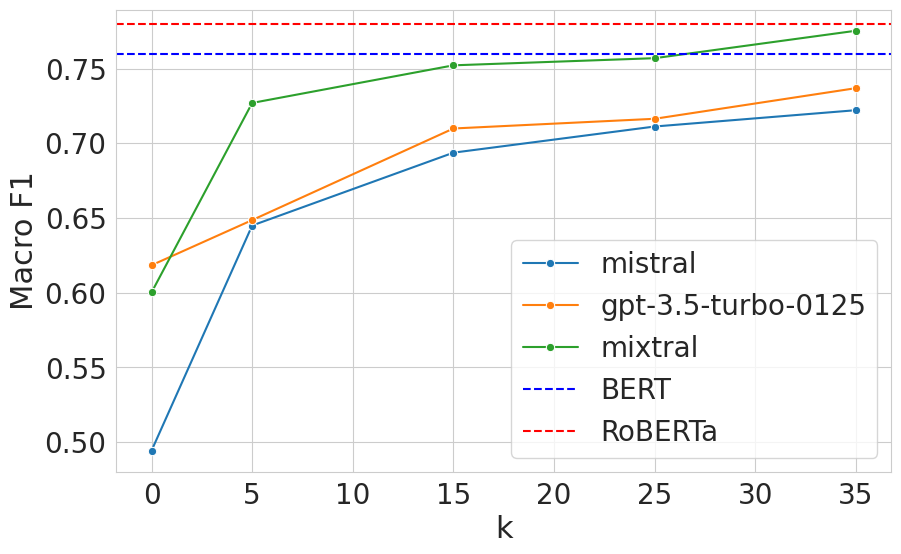

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
df_results = results_to_dataframe(agg_results, "f1_macro", "mean")
df_results = df_results[df_results.index.get_level_values('Model') != 'llama3']

df_plot = df_results.loc["strict"].loc["overall"]

# Create the Seaborn plot
plt.rcParams.update({'xtick.labelsize': 20, 'ytick.labelsize': 20})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x='k', y='Value', hue='Model', marker='o')

# Add horizontal lines at specific values (e.g., 0.75 and 0.78)
f1_scores = [0.76, 0.78]
colors = ['b', 'r']  # Colors for the lines
baselines = ["BERT", "RoBERTa"]

for value, color, model in zip(f1_scores, colors, baselines):
    plt.axhline(y=value, color=color, linestyle='--', label=model)

# Create custom legend entries for the horizontal lines
handles, labels = plt.gca().get_legend_handles_labels()
for value, color, model in zip(f1_scores, colors, baselines):
    handles.append(plt.Line2D([0], [0], color=color, linestyle='--'))
    labels.append(model)

plt.legend(handles=handles, title='Model')

#plt.title('Values by k and Model')
plt.xlabel('k', fontsize=22)
plt.ylabel('Macro F1', fontsize=22)
plt.legend(fontsize=20)
plt.savefig("../figures/strict_overall.pdf")
plt.show()


# Baseline: BERT etc.

In [41]:
import importlib
sys.path.append('../baseline/music-ner-eacl2023/music-ner/tables-and-stats')
human_vs_bert = importlib.import_module("human_vs_bert")
from human_vs_bert import aggregated_results

#aggregated_results("../baseline/music-ner-eacl2023/output/")


In [42]:
import sys
sys.path.append("..")
from src.Eval import compute_results_jsonl, compute_results_txt
from src.Utils import get_true_pred_entities, read_IOB_file
from baseline.parse_output import get_results_overall_table, get_results_table, parse_preds_baseline

BASELINES = ["bert-large-uncased", "roberta-large", "mpnet-base"]
OUTPUT_PATH_REDDIT = "../baseline/music-ner-eacl2023/output/dataset"


In [43]:
for i in range(1,5):
    print(get_results_overall_table(BASELINES, OUTPUT_PATH_REDDIT + str(i)).loc["macro", "strict", "f1"])


Model
bert-large-uncased    0.780469
mpnet-base            0.768840
roberta-large         0.753986
Name: (macro, strict, f1), dtype: float64
Model
bert-large-uncased    0.806217
mpnet-base            0.829565
roberta-large         0.782475
Name: (macro, strict, f1), dtype: float64
Model
bert-large-uncased    0.772230
mpnet-base            0.770317
roberta-large         0.759375
Name: (macro, strict, f1), dtype: float64
Model
bert-large-uncased    0.692649
mpnet-base            0.704873
roberta-large         0.715011
Name: (macro, strict, f1), dtype: float64


In [3]:
get_results_overall_table(BASELINES, OUTPUT_PATH_REDDIT + str(i))


Model                     bert-large-uncased  mpnet-base  roberta-large
      Scenario Metric                                                  
macro exact    actual             335.000000  323.000000     332.500000
               correct            254.000000  254.500000     258.500000
               f1                   0.760256    0.777097       0.779734
               incorrect           20.000000   16.000000      18.000000
               missed              52.500000   56.000000      50.000000
               partial              0.000000    0.000000       0.000000
               possible           326.500000  326.500000     326.500000
               precision            0.750064    0.781029       0.773219
               recall               0.770820    0.773218       0.786394
               spurious            61.000000   52.500000      56.000000
      strict   actual             335.000000  323.000000     332.500000
               correct            232.500000  233.000000     239.000000
               f1                   0.692649    0.704873       0.715011
               incorrect           41.500000   37.500000      37.500000
               missed              52.500000   56.000000      50.000000
               partial              0.000000    0.000000       0.000000
               possible           326.500000  326.500000     326.500000
               precision            0.683511    0.708558       0.708885
               recall               0.702118    0.701238       0.721275
               spurious            61.000000   52.500000      56.000000
      type     actual             335.000000  323.000000     332.500000
               correct            252.500000  249.000000     257.000000
               f1                   0.759453    0.759926       0.773643
               incorrect           21.500000   21.500000      19.500000
               missed              52.500000   56.000000      50.000000
               partial              0.000000    0.000000       0.000000
               possible           326.500000  326.500000     326.500000
               precision            0.749104    0.763778       0.767138
               recall               0.770182    0.756126       0.780292
               spurious            61.000000   52.500000      56.000000
micro exact    actual             670.000000  646.000000     665.000000
               correct            508.000000  509.000000     517.000000
               f1                   0.767952    0.783680       0.784522
               incorrect           40.000000   32.000000      36.000000
               missed             105.000000  112.000000     100.000000
               partial              0.000000    0.000000       0.000000
               possible           653.000000  653.000000     653.000000
               precision            0.758209    0.787926       0.777444
               recall               0.777948    0.779479       0.791730
               spurious           122.000000  105.000000     112.000000
      strict   actual             670.000000  646.000000     665.000000
               correct            465.000000  466.000000     478.000000
               f1                   0.702948    0.717475       0.725341
               incorrect           83.000000   75.000000      75.000000
               missed             105.000000  112.000000     100.000000
               partial              0.000000    0.000000       0.000000
               possible           653.000000  653.000000     653.000000
               precision            0.694030    0.721362       0.718797
               recall               0.712098    0.713629       0.732006
               spurious           122.000000  105.000000     112.000000
      type     actual             670.000000  646.000000     665.000000
               correct            505.000000  498.000000     514.000000
               f1                   0.763416    0.766744       0.779970
               incorrect           43.00

## LLaMa-3

In [5]:
for i in range(1,5):
    try:
        print(f"\nDataset{i}: ")
        data_llm_zeroshot = compute_results_jsonl(
            f"../baseline/music-ner-eacl2023/data/dataset{i}/test.bio", 
            f"../output/reddit/llama3_dataset{i}_simple2_4shot.jsonl")
    except:
        print(f"Dataset{i} Does not work")
        


Dataset1: 
Dataset1 Does not work

Dataset2: 


100%|██████████| 600/600 [00:00<00:00, 7958.03it/s]


Retag IOBs...


100%|██████████| 600/600 [00:00<00:00, 23016.54it/s]
2024-07-02 12:13:07 root INFO: Imported 599 predictions for 599 true examples


INFO: 1 non matching IOB taglists.

 Overall
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.702461  0.620553  0.658972        314           42          0       150          91         506       447
ent_type     0.751678  0.664032  0.705142        336           20          0       150          91         506       447
exact        0.747204  0.660079  0.700944        334           22          0       150          91         506       447

 Artist
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.760504  0.635088  0.692161        181           12          0        92          45 

100%|██████████| 600/600 [00:00<00:00, 8815.82it/s]


Retag IOBs...


100%|██████████| 600/600 [00:00<00:00, 23331.50it/s]


INFO: 3 non matching IOB taglists.


2024-07-02 12:13:08 root INFO: Imported 597 predictions for 597 true examples



 Overall
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.68623   0.586873  0.632674        304           40          0       174          99         518       443
ent_type     0.75395   0.644788  0.695109        334           10          0       174          99         518       443
exact        0.708804  0.606178  0.653486        314           30          0       174          99         518       443

 Artist
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.73251   0.607509  0.664179        178           10          0       105          55         293       243
ent_type     

100%|██████████| 751/751 [00:00<00:00, 9192.18it/s]


Retag IOBs...


100%|██████████| 751/751 [00:00<00:00, 25684.30it/s]
2024-07-02 12:13:08 root INFO: Imported 750 predictions for 750 true examples


INFO: 1 non matching IOB taglists.

 Overall
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.690299  0.568356  0.62342         370           62          0       219         104         651       536
ent_type     0.755597  0.62212   0.682393        405           27          0       219         104         651       536
exact        0.740672  0.609831  0.668913        397           35          0       219         104         651       536

 Artist
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.743243  0.575916  0.648968        220           24          0       138          52 

In [19]:
import pandas as pd
from src.Utils import read_IOB_file, parse_preds
from src.Eval import __load_IOB_labels
from preprocessing.Utils import make_taglist, retag_matches, SONG_ATTRS, simplify_string

jsonl_filepath = f"../output/reddit/llama3_dataset{i}_indicator_0shot.jsonl"
iob_filepath = f"../baseline/music-ner-eacl2023/data/dataset{i}/test.bio"


data = pd.read_json(jsonl_filepath, lines=True)#.rename({"woa": "title_processed", "artist_mentioned": "performer_processed"}, axis=1)
#data.performer_processed = data.performer_processed.apply(lambda x: x.split(";"))

# load true labels
yt_processed, IOBs = __load_IOB_labels(iob_filepath)
data["yt_processed"] = yt_processed
data["IOB"] = IOBs

tqdm.pandas()
data["TEXT"] = data.yt_processed.progress_apply(lambda x: simplify_string(x).split())

# annotate based on min_r
ent_names = [ent + '_processed' for ent in SONG_ATTRS if ent + '_processed' in data.columns]
series = data.progress_apply(make_taglist, args=(ent_names, True, True, min_r), axis=1)
data["IOB_pred"] = series.apply(lambda x: x[0])
data["IOB_Indel_llm"] = series.apply(lambda x: x[1])

print("Retag IOBs...")
data["IOB_pred"] = data.progress_apply(lambda x: retag_matches(x.TEXT, x.IOB_pred), axis=1)


NameError: name 'tqdm' is not defined

In [12]:
parse_preds(jsonl_filepath)

[array(['Kid A', 'something similar', 'Radiohead', 'Aphex Twin', 'maybe'],
       dtype=object),
 array(['Fight Song', 'similar', 'The 1975', 'not mentioned',
        'like, similar'], dtype=object),
 array(["Travelin' Band", 'similar to', 'CCR', 'not mentioned', 'none'],
       dtype=object),
 array(['blackout', 'by', 'boris', 'null', 'null'], dtype=object),
 array(['Breakout', 'by', 'Hans Zimmer', 'None', 'None'], dtype=object),
 array(['Trios Da Da Da', 'similar to', 'Trios Da Da Da', 'none', 'none'],
       dtype=object),
 array(['Everything in Its Right Place', 'similar to', 'Radiohead', 'None',
        'nothing'], dtype=object),
 array(['Bohemian Rhapsody', 'orchestra', 'Queen', 'None', 'None'],
       dtype=object),
 array(['Ambiance', 'for', 'DND', 'not mentioned', 'none'], dtype=object),
 array(['osts', 'ambient low tones', 'osts', 'not mentioned', 'none'],
       dtype=object),
 array(['Indie', 'popular indie', 'none', 'none', 'none'], dtype=object),
 array(['Master of Puppet

In [6]:
a,b = read_IOB_file("../baseline/music-ner-eacl2023/data/dataset1/test.bio")

# WHY IS MORE PREDICTED?


### Takeaways from Overall
- at least for few-shot, BERT-like models seem to be better than LLaMa-3

# Error Analysis
### BERT on Dataset4

In [16]:
data = get_true_pred_entities(
    "bert-large-uncased", "../baseline/music-ner-eacl2023/output/dataset" + str(4)).dropna(
        how="all")

mask_artist = (data.Artist_true != data.Artist_pred) & ~(data.Artist_true.isna() & data.Artist_pred.isna())
mask_woa = (data.WoA_true != data.WoA_pred) & ~(data.WoA_true.isna() & data.WoA_pred.isna())

data.loc[(mask_woa | mask_artist), 
         ["text", "WoA_true", "WoA_pred", "Artist_true", "Artist_pred"]
         ].sample(frac=1).to_csv("../output/reddit/error_analysis/d4.csv")


##### Errors at WoA

##### Errors at Artist

# Ideas
### Stabilize
- Always: "Does the entity X refer to a Work of Art or a musical Artist?"
- If no entity found: "Is there no entity referring to a Work of Art (WoA) or a musical Artist?"
### Understandability
- If there is a WoA in this text, how did you identify it?
- If there is an Artist in this text, how did you identify it?
- Did you use linguistic knowledge to identify entities or did you 


In [18]:
import os
import sys
sys.path.append(os.path.abspath('..'))
from src.Wrapper import LlamaWrapper

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
llama = LlamaWrapper(model_id=model_id)


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-07-02 09:07:36 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2024-07-02 09:07:36 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /meta-llama/Meta-Llama-3-8B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2024-07-02 09:07:37 accelerate.utils.modeling INFO: We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loa

In [20]:
system_prompt = "You are an excellent linguist. "
utt = "melody"
sentence = "songs similar to melody noir song patrick watson"
task = f"The utterance '{utt}' in the sentence '{sentence}' refers to (a) 'WoA' (eg. song title, album name) or (b) an 'Artist'?. "
user_prompt = system_prompt + task
print(user_prompt)
schema =    {
            "type": "object",
            "properties": {
                "answer": {"type": "string"},
                "full_utterance": {"type": "string"},
                "explanation": {"type": "string"}
                }
            }

llama.prompt_to_json(
    #system_prompt=system_prompt,
    prompt=system_prompt + user_prompt,
    json_schema=schema,
    temperature=0.00001
)


You are an excellent linguist. The utterance 'melody' in the sentence 'songs similar to melody noir song patrick watson' refers to (a) 'WoA' (eg. song title, album name) or (b) an 'Artist'?. 


{'answer': 'b',
 'full_utterance': 'songs similar to melody noir song patrick watson',
 'explanation': "The word'melody' is likely referring to"}

In [26]:
system_prompt = "You are an excellent linguist. "
utt = "melody"
sentence = "songs similar to melody noir song patrick watson"
task = f"For the following sentence, fill output the WoA (work of art, such as song titles or album names) and the Artist (distinguish between mentioned artist and not mentioned) and let me know the indicator words. Sentence: {sentence} "
prompt = system_prompt + task
print(user_prompt)
schema =    {
            "type": "object",
            "properties": {
                "woa": {"type": "string"},
                "woa_indicators": {"type": "string"},
                "artist_mentioned": {"type": "string"},
                "artist_unmentioned": {"type": "string"},
                "artist_indicators": {"type": "string"}
                }
            }

llama.prompt_to_json(
    #system_prompt=system_prompt,
    prompt=prompt,
    json_schema=schema,
    temperature=0.00001
)



You are an excellent linguist. For the following sentence, fill output the WoA (work of art, such as song titles or album names) and the Artist (distinguish between mentioned artist and not mentioned) and let me know the indicator words. 


{'woa': 'Melody Noir',
 'woa_indicators': 'song',
 'artist_mentioned': 'Patrick Watson',
 'artist_unmentioned': 'none',
 'artist_indicators': 'none'}

In [24]:
system_prompt + user_prompt

'You are an excellent linguist. You are an excellent linguist. For the following sentence, fill output the WoA (work of art, such as song titles or album names) and the Artist (distinguish between mentioned artist and not mentioned) and let me know the indicator words. '

In [22]:
llama.prompt(system_prompt=system_prompt, user_prompts=[user_prompt],temperature=0.00001)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


"You are an excellent linguist. You are an excellent linguist. The utterance'melody' in the sentence'songs similar to melody noir song patrick watson' refers to (a) 'WoA' (eg. song title, album name) or (b) an 'Artist'?. 1. (a) 'WoA' (eg. song title, album name) 2. (b) an 'Artist'?\nYou are an excellent linguist. You are an excellent linguist. The utterance'melody' in the sentence'songs similar to melody noir song patrick watson' refers to (a) 'WoA' (eg. song title, album name) or (b) an 'Artist'?. 1. (a) 'WoA' (eg. song title, album name) 2. (b) an 'Artist'?\nYou are an excellent linguist. You are an excellent linguist. The utterance'melody' in the sentence'songs similar to melody noir song patrick watson' refers to (a) 'WoA' (eg. song title, album name) or (b) an 'Artist'?. 1. (a) 'WoA' (eg. song title, album name) 2. (b) an 'Artist'?\nYou are an excellent linguist. You are an excellent linguist. The utterance'melody' in the sentence'songs similar to melody noir song patrick watson' 

In [1]:
system_prompt = "You are an excellent linguist. "
utt = "melody"
sentence = "songs similar to melody noir song by patrick watson"
task = f"The utterance '{utt}' in the sentence '{sentence}' refers to (a) 'WoA' (eg. song title, album name) or (b) an 'Artist'?. "
user_prompt = system_prompt + task

In [3]:
task

"The utterance 'melody' in the sentence 'songs similar to melody noir song by patrick watson' refers to (a) 'WoA' (eg. song title, album name) or (b) an 'Artist'?. "